Research question 3: How meaningful are the extracted concepts?


In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize

blackbox_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

def preprocess_images(img_array):
    img_array = np.array([tf.image.resize(img_to_array(img), (224, 224)) for img in img_array])
    return preprocess_input(img_array)

def black_box_classify(img_array,convert_to_nr=True):
    preprocessed_imgs = preprocess_images(img_array)
    predictions = blackbox_model.predict(preprocessed_imgs)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    if convert_to_nr:
        label_as_nr = label_encoder.transform(labels_as_str)
        return [[l]for l in label_as_nr]
    return [[l]for l in labels_as_str]

def black_box_lime(temp):
    resized_temp = resize(temp, (224, 224), mode='reflect', preserve_range=True).astype(np.uint8)
    resized_temp = np.expand_dims(resized_temp, axis=0)
    predictions = blackbox_model.predict(resized_temp)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    label_as_nr = label_encoder.transform(labels_as_str)
    return [[l]for l in label_as_nr]

In [4]:
import numpy as np
import pickle
import hashlib
import pandas as pd

np.random.seed(42)

base_path = "/Users/karlgustav/Documents/GitHub/study/master-thesis/server/src/research/"
# base_path = "/Users/karl-gustav.kallasmaa/Documents/Projects/master-thesis/server/src/"
all_labels_path = f"{base_path}all_classes.txt"
all_concepts_path = f"{base_path}all_concepts.txt"
masks_path = f"{base_path}data/masks.pkl"
img_path = f"{base_path}data/resized_imgs.pkl"
labels_path = f"{base_path}data/classes.pkl"
ade_path = f"{base_path}data/objectInfo150.csv"

ade_classes = pd.read_csv(ade_path)

images = []
masks = []
unique_labels = []
with open(masks_path, 'rb') as f:
    masks = pickle.load(f)
with open(img_path, 'rb') as f:
    images = pickle.load(f)
with open(all_labels_path) as f:
    lines = f.read().splitlines()
    lines = [l.replace(' ', '_') for l in lines]
    unique_labels = np.array(list(set(lines)))

labels = black_box_classify(images,False)
labels = [l[0] for l in labels]

all_concept_values = ade_classes['Name'].tolist()
UNIQUE_CONCEPT_VALUES = sorted(list(set(all_concept_values)))
NR_OF_UNIQUE_CONCEPTS = len(UNIQUE_CONCEPT_VALUES)


image_hex_index_map = {hashlib.sha1(np.array(img).view(np.uint8)).hexdigest(): i for i,img in enumerate(images)}

index_img_map = {i:img for i,img in enumerate(images)}
index_label_map = {i:label for i,label in enumerate(labels)}
index_mask_map = {i:mask for i,mask in enumerate(masks)}
index_ade_map = {i:ade for i,ade in enumerate(ade_classes)}

test_image_count = 10

random_indexes = np.random.choice(list(index_img_map.keys()), test_image_count, replace=False)

random_images = [index_img_map[index] for index in random_indexes]
random_labels = np.array([index_label_map[index] for index in random_indexes])
random_masks = [index_mask_map[index] for index in random_indexes]

print("Total number of images "+str(len(images)))
print("Number of images used "+str(len(random_images)))

50/50 [==============================] - 32s 633ms/step
Total number of images 1592
Number of images used 10


Propose concepts

In [8]:
from operator import itemgetter
from typing import Dict, List

def get_segments(img, mask, threshold=0.05):
    segs = np.unique(mask)
    segments = []
    total = mask.shape[0] * mask.shape[1]
    segments_classes = []
    
    for seg in segs:
        idxs = mask == seg
        sz = np.sum(idxs)
        
        if sz < threshold * total:
            continue
        
        coords = np.argwhere(idxs)
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)
        
        segment_img = img[x_min:x_max+1, y_min:y_max+1, :]
        
        segments.append(segment_img)
        segments_classes.append(ade_classes['Name'].loc[ade_classes['Idx'] == seg].iloc[0])
    
    return segments, segments_classes

def sort_dictionary(source: Dict[any, any], by_value=True, reverse=True) -> List[any]:
    if by_value:
        return sorted(source.items(), key=itemgetter(1), reverse=reverse)
    return sorted(source.items(), key=itemgetter(0), reverse=reverse)

In [41]:
from typing import Dict, List
from mpire import WorkerPool
from functools import reduce

class MostPopularConcepts:
    BATCH_SIZE = 10
    MAX_WORKER_COUNT = 8

    def __init__(self,l_labels,i_images,m_maks):
        all_labels = np.array(l_labels)
        chunk_size = max(1, int(all_labels.size / self.BATCH_SIZE))
        self.labels_in_chunks = np.array_split(all_labels, chunk_size)
        self.nr_of_jobs = min(self.MAX_WORKER_COUNT, len(self.labels_in_chunks))

        self.label_images_map = {}
        self.label_masks_map = {}

        self.image_most_popular_concepts = self.static_most_popular_concepts(l_labels,i_images,m_maks)

    def static_most_popular_concepts(self,l_labels,i_images,m_maks) -> Dict[str, List[any]]:
        for label, image, mask in zip(l_labels,i_images,m_maks):
            current_images = self.label_images_map.get(label, [])
            current_maks = self.label_masks_map.get(label, [])

            current_images.append(image)
            current_maks.append(mask)

            self.label_images_map[label] = current_images
            self.label_masks_map[label] = current_maks

        with WorkerPool(n_jobs=self.nr_of_jobs) as pool:
            return reduce(lambda a, b: {**a, **b},
                          pool.map(self.__extract_most_popular_concepts, self.labels_in_chunks))

    def __extract_most_popular_concepts(self, l_labels: List[str]) -> Dict[str, List[any]]:
        partial_results = {}
        for label in  l_labels:
            i_images = self.label_images_map[label]
            m_masks = self.label_masks_map[label]
            nr_of_images = len(i_images)
            partial_results[label] = self.most_popular_concepts(images,m_masks, nr_of_images)
        return partial_results

    @staticmethod
    def most_popular_concepts(i_images, m_masks, k) -> List[str]:
        segment_count = {}
        for pic, mask in zip(i_images, m_masks):
            _, seg_class = get_segments(np.array(pic), mask, threshold=0.005)
            for s in seg_class:
                segment_count[s] = segment_count.get(s, 0) + 1
        segment_count = sort_dictionary(segment_count)
        if len(segment_count) < k:
            return [s for s, _ in segment_count]
        return [s for s, _ in segment_count[:k]]

In [42]:
mpc_service = MostPopularConcepts(labels,images,masks)
MOST_POPULAR_CONCEPTS = mpc_service.image_most_popular_concepts

Reccord random and non random results

In [68]:
import random

def random_concepts(correct_concepts,label,image,mask,random_concept_count=4):
    popular_concepts_in_img = mpc_service.most_popular_concepts([image],[mask],1000)
    popular_concepts_in_img = [c for c in popular_concepts_in_img if c not in correct_concepts]
    if len(popular_concepts_in_img) >= random_concept_count:
        return [c for c in popular_concepts_in_img[:random_concept_count]]
    
    all_labels = list(MOST_POPULAR_CONCEPTS.keys())
    all_labels = [l for l in all_labels if l != label]
    
    while True:
        if len(popular_concepts_in_img) >= random_concept_count:
            return [c for c in popular_concepts_in_img[:random_concept_count]]
        random_label = random.choice(all_labels)
        random_concepts = [c for c in MOST_POPULAR_CONCEPTS[random_label] if c not in correct_concepts]
        random_concepts = [c for c in random_concepts if c not in popular_concepts_in_img]
        popular_concepts_in_img = popular_concepts_in_img + random_concepts

def experiment_solultions(l_labels,i_images,m_masks,correct_concept_count=4):
    solutions = []
    i = 0
    for label,mask,image in zip(l_labels,i_images,m_masks):
        framework_proposed_concepts = MOST_POPULAR_CONCEPTS[label][0:correct_concept_count]
        chosen_random_concepts = random_concepts(framework_proposed_concepts,label,mask,image)
          
        combined = framework_proposed_concepts + chosen_random_concepts
        random.shuffle(combined)
        
        exp = {
            "nr":i+1,
            "label":label,
            "correct":framework_proposed_concepts,
            "random":chosen_random_concepts,
            "combined":combined
        }
        solutions.append(exp)
        i += 1
    return solutions

In [65]:
solutions = experiment_solultions(random_labels,random_images,random_masks)

In [56]:
import uuid
import os
from PIL import Image
import matplotlib.pyplot as plt


def temp_img(index):
    image_pil = random_images[index]
    temp_image_path = str(uuid.uuid4())+".jpg"
    image_pil.save(temp_image_path)
    return temp_image_path

def vizualise_img(path):
    open_image = Image.open(path)
    plt.imshow(open_image)
    plt.axis('off')
    plt.show()
    os.remove(path)
    
def vizualise_explanation(index):
    correct_label = random_labels[index]
    
    temp_image_path = temp_img(index)
    vizualise_img(temp_image_path)
    
    solution = solutions[index]
    print("Label: "+solution["label"])
        
    print("Correct concepts")
    print(solution["correct"])
    
    
    print("Combined concepts")
    print(solution["combined"])
    

Image 0


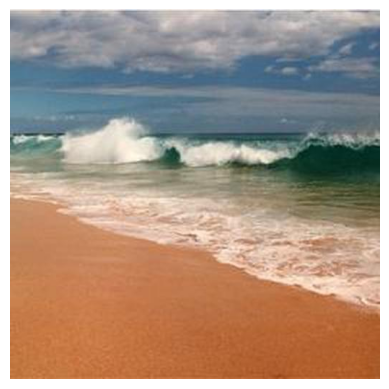

Label: seashore
Correct concepts
['sky', 'sea', 'sand', 'mountain;mount']
Combined concepts
['tree', 'sky', 'sand', 'signboard;sign', 'sea', 'mountain;mount', 'building;edifice', 'road;route']
Image 1


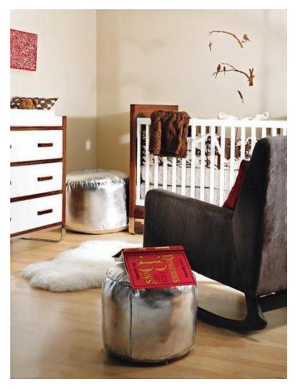

Label: studio_couch
Correct concepts
['wall', 'floor;flooring', 'bed', 'windowpane;window']
Combined concepts
['book', 'wall', 'floor;flooring', 'windowpane;window', 'chest;of;drawers;chest;bureau;dresser', 'armchair', 'bed', 'rug;carpet;carpeting']
Image 2


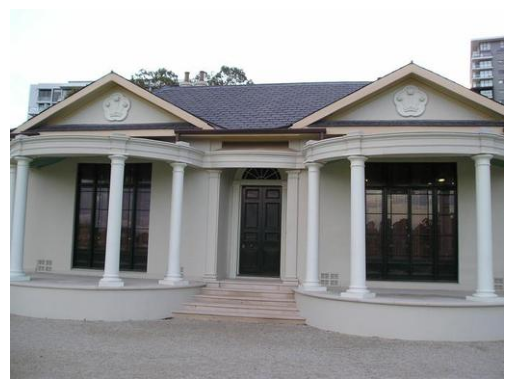

Label: tile_roof
Correct concepts
['sky', 'tree', 'house', 'road;route']
Combined concepts
['road;route', 'house', 'mountain;mount', 'tree', 'sky', 'bridge;span', 'water', 'grass']
Image 3


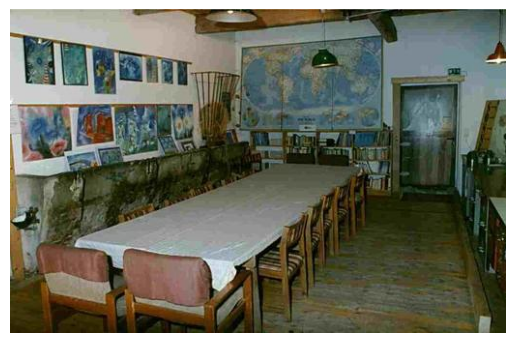

Label: restaurant
Correct concepts
['wall', 'floor;flooring', 'ceiling', 'chair']
Combined concepts
['table', 'door;double;door', 'ceiling', 'armchair', 'floor;flooring', 'painting;picture', 'chair', 'wall']
Image 4


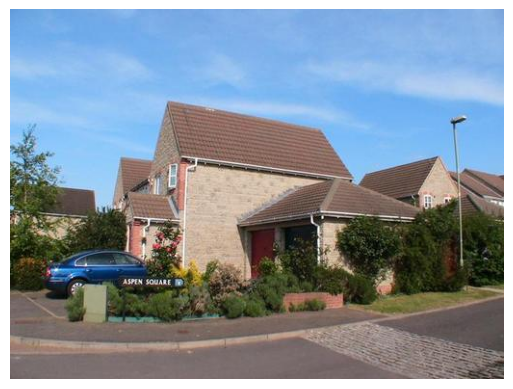

Label: tile_roof
Correct concepts
['sky', 'tree', 'house', 'road;route']
Combined concepts
['sky', 'tree', 'grass', 'road;route', 'plant;flora;plant;life', 'car;auto;automobile;machine;motorcar', 'sidewalk;pavement', 'house']
Image 5


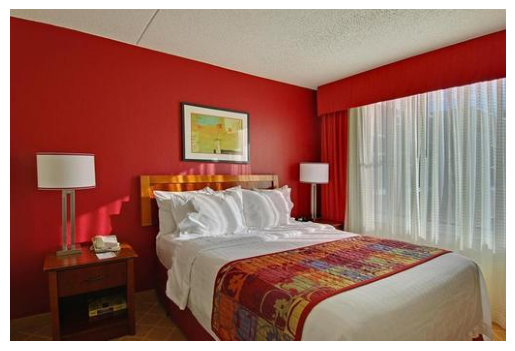

Label: quilt
Correct concepts
['wall', 'bed', 'floor;flooring', 'painting;picture']
Combined concepts
['wall', 'curtain;drape;drapery;mantle;pall', 'floor;flooring', 'bed', 'table', 'lamp', 'ceiling', 'painting;picture']
Image 6


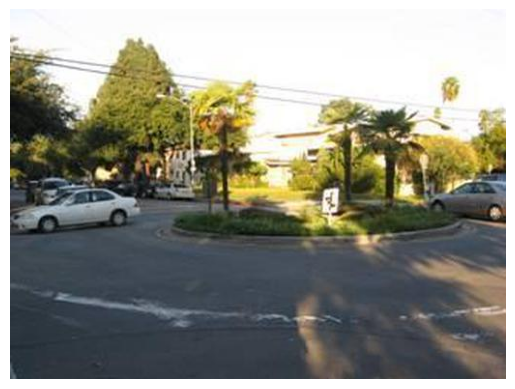

Label: motor_scooter
Correct concepts
['building;edifice']
Combined concepts
['grass', 'building;edifice', 'house', 'plant;flora;plant;life', 'sky', 'car;auto;automobile;machine;motorcar', 'road;route', 'tree']
Image 7


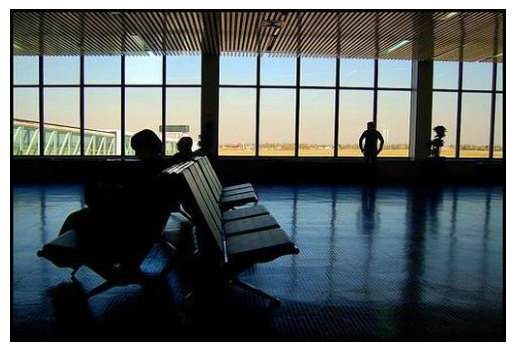

Label: accordion
Correct concepts
['wall', 'floor;flooring']
Combined concepts
['skyscraper', 'sky', 'building;edifice', 'seat', 'wall', 'windowpane;window', 'person;individual;someone;somebody;mortal;soul', 'floor;flooring']
Image 8


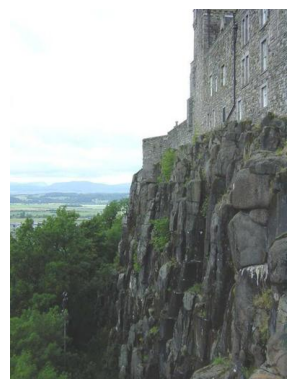

Label: cliff
Correct concepts
['sky', 'mountain;mount']
Combined concepts
['wall', 'tree', 'building;edifice', 'windowpane;window', 'sky', 'skyscraper', 'land;ground;soil', 'mountain;mount']
Image 9


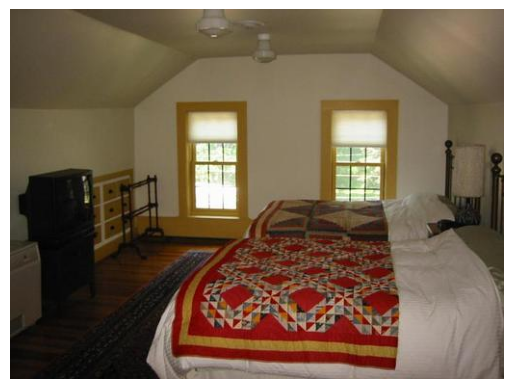

Label: quilt
Correct concepts
['wall', 'bed', 'floor;flooring', 'painting;picture']
Combined concepts
['cabinet', 'rug;carpet;carpeting', 'ceiling', 'bed', 'wall', 'windowpane;window', 'floor;flooring', 'painting;picture']


In [76]:
# Image 1
# 6 7 8 9
for i in range(10):
    print("Image "+str(i))
    vizualise_explanation(i)